In [ ]:
import os
import pydicom
import numpy as np
import cv2
import nibabel as nib

def load_dicom_image(dicom_path, image_size=(128, 128)):
    dicom = pydicom.dcmread(dicom_path)
    img_array = dicom.pixel_array
    img_array = img_array.astype(np.float32) 
    min_val = np.min(img_array)
    max_val = np.max(img_array)
    range_val = max_val - min_val
    
    if range_val == 0: 
        img_array = np.zeros_like(img_array)
    else:
        img_array = (img_array - min_val) / range_val
    
    img_array = cv2.resize(img_array, image_size, interpolation=cv2.INTER_LINEAR)
    
    return img_array

def load_dicom_series(directory, num_slices=600, image_size=(128, 128)):
    dicom_files = [os.path.join(root, file)
                   for root, _, files in os.walk(directory)
                   for file in files if file.endswith('.dcm')]
    
    dicom_files.sort()
    images = [load_dicom_image(f, image_size) for f in dicom_files]

    if len(images) < num_slices:
        empty_slice = np.zeros(image_size)
        num_missing_slices = num_slices - len(images)
        images.extend([empty_slice] * num_missing_slices) 

    images = images[:num_slices]
    
    return np.stack(images, axis=-1)

def save_nifti(image_3d, output_path):
    output_dir = os.path.dirname(output_path)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)
    nifti_image = nib.Nifti1Image(image_3d, affine=np.eye(4))
    nib.save(nifti_image, output_path)
    print(f"NIfTI file saved to: {output_path}")

def process_patient(patient_dir, output_base_dir, num_slices=600, image_size=(128, 128)):
    dicom_series = load_dicom_series(patient_dir, num_slices, image_size)
    patient_name = os.path.basename(patient_dir)
    output_path = os.path.join(output_base_dir, f"{patient_name}.nii")
    print(f"Saving NIfTI to: {output_path}")
    save_nifti(dicom_series, output_path)
    print(f"Finished processing: {output_path}")

def process_all_patients(data_dir, output_dir, num_slices=600, image_size=(128, 128)):
    for root, dirs, files in os.walk(data_dir):
        if any(file.endswith('.dcm') for file in files):
            relative_path = os.path.relpath(root, start=data_dir)
            patient_output_dir = os.path.join(output_dir, relative_path)
            process_patient(root, patient_output_dir, num_slices, image_size)

data_dir = r'C:\Users\Archana G\OneDrive\Desktop\My projects\MiniProject\data'
output_dir = r'C:\Users\Archana G\OneDrive\Desktop\My projects\MiniProject\nifti_data'

print(f"Current working directory: {os.getcwd()}")

if not os.path.exists(data_dir):
    print(f"Directory does not exist: {data_dir}")
else:
    print("Starting the process...")
    process_all_patients(data_dir, output_dir, num_slices=600, image_size=(128, 128))
    print("Process finished.")


In [ ]:
import os
import nibabel as nib
import numpy as np

def flip_image(image_3d, flip_axis=0):
    return np.flip(image_3d, axis=flip_axis)

def rotate_image(image_3d, rotation_angle=90):
    if rotation_angle == 90:
        return np.rot90(image_3d, k=1, axes=(0, 1))  
    elif rotation_angle == 180:
        return np.rot90(image_3d, k=2, axes=(0, 1))  
    elif rotation_angle == 270:
        return np.rot90(image_3d, k=3, axes=(0, 1))  
    else:
        return image_3d 

def process_nifti_file(nifti_file):

    nifti_image = nib.load(nifti_file)
    image_data = nifti_image.get_fdata()

    original_folder = os.path.dirname(nifti_file)
    base_filename = os.path.basename(nifti_file).replace('.nii', '')

    flipped_image = flip_image(image_data, flip_axis=0) 
    flipped_filename = f"{base_filename}_flipped.nii"
    flipped_output_path = os.path.join(original_folder, flipped_filename)
    nib.save(nib.Nifti1Image(flipped_image, nifti_image.affine), flipped_output_path)
    print(f"Saved flipped image: {flipped_output_path}")
    
    rotated_image = rotate_image(image_data, rotation_angle=90) 
    rotated_filename = f"{base_filename}_rotated.nii"
    rotated_output_path = os.path.join(original_folder, rotated_filename)
    nib.save(nib.Nifti1Image(rotated_image, nifti_image.affine), rotated_output_path)
    print(f"Saved rotated image: {rotated_output_path}")

def process_all_nifti_files(base_dir):

    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.nii'):
                nifti_file_path = os.path.join(root, file)
                process_nifti_file(nifti_file_path)

base_dir = r'C:\Users\Archana G\OneDrive\Desktop\My projects\MiniProject\nifti_data'
process_all_nifti_files(base_dir)

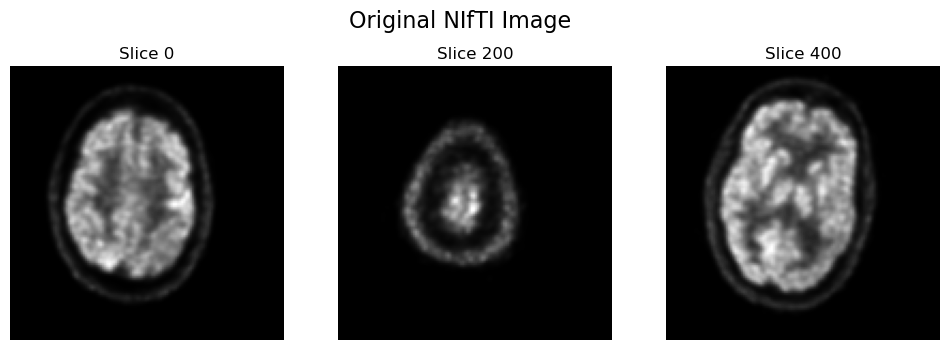

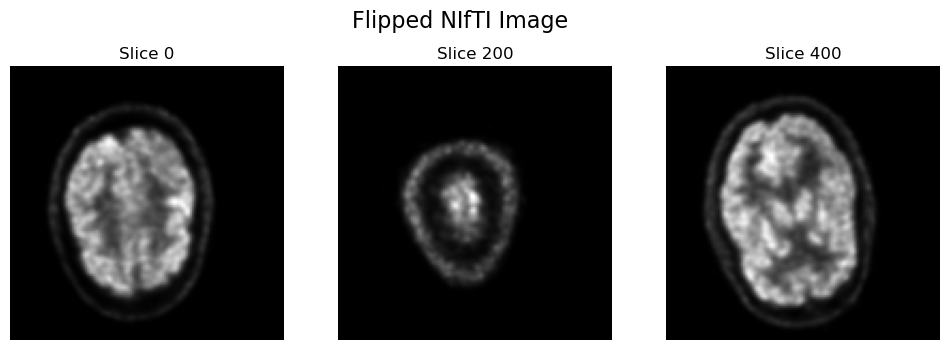

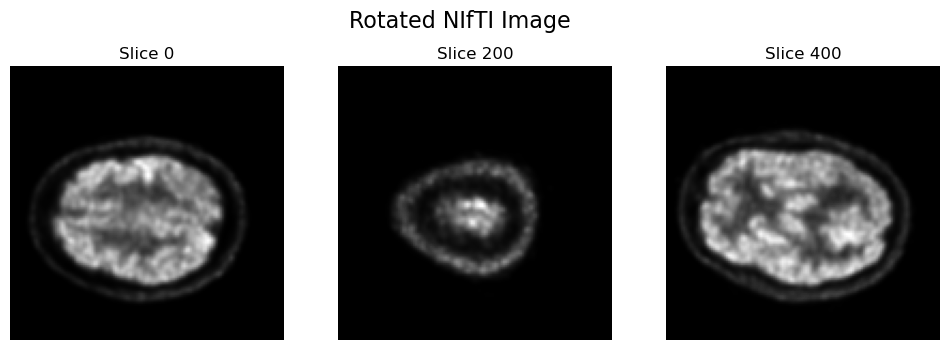

In [2]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

def visualize_nifti_slices(nifti_file, num_slices=3, title=""):
    nifti_image = nib.load(nifti_file)
    image_data = nifti_image.get_fdata()

    total_slices = image_data.shape[-1]  
    step = total_slices // num_slices 

    fig, axs = plt.subplots(1, num_slices, figsize=(12, 4))
    fig.suptitle(title, fontsize=16)

    for i in range(num_slices):
        slice_index = i * step
        axs[i].imshow(image_data[:, :, slice_index], cmap='gray')
        axs[i].set_title(f"Slice {slice_index}")
        axs[i].axis('off')

    plt.show()

nifti_original = r"C:\Users\Archana G\OneDrive\Desktop\My projects\MiniProject\nifti_data\AD\ADNI\002_S_5018\ADNI_Brain_PET__Raw_FDG\2012-11-14_08_14_11.0\I346569\I346569.nii"
nifti_flipped = r"C:\Users\Archana G\OneDrive\Desktop\My projects\MiniProject\nifti_data\AD\ADNI\002_S_5018\ADNI_Brain_PET__Raw_FDG\2012-11-14_08_14_11.0\I346569\I346569_flipped.nii"
nifti_rotated = r"C:\Users\Archana G\OneDrive\Desktop\My projects\MiniProject\nifti_data\AD\ADNI\002_S_5018\ADNI_Brain_PET__Raw_FDG\2012-11-14_08_14_11.0\I346569\I346569_rotated.nii"

visualize_nifti_slices(nifti_original, num_slices=3, title="Original NIfTI Image")
visualize_nifti_slices(nifti_flipped, num_slices=3, title="Flipped NIfTI Image")
visualize_nifti_slices(nifti_rotated, num_slices=3, title="Rotated NIfTI Image")


Visualizing AD: C:/Users/Archana G/OneDrive/Desktop/My projects/MiniProject/nifti_data\AD\ADNI\002_S_5018\ADNI_Brain_PET__Raw_FDG\2012-11-14_08_14_11.0\I346569\I346569.nii


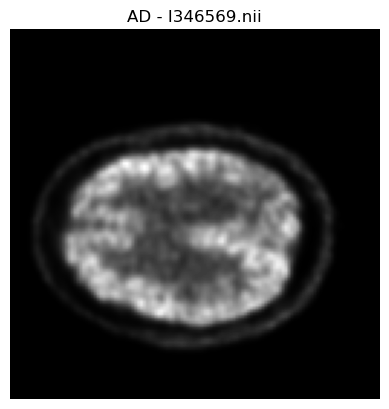

Visualizing CN: C:/Users/Archana G/OneDrive/Desktop/My projects/MiniProject/nifti_data\CN\ADNI\002_S_0295\ADNI_Brain_PET__Raw_FDG\2011-06-09_08_23_48.0\I239487\I239487.nii


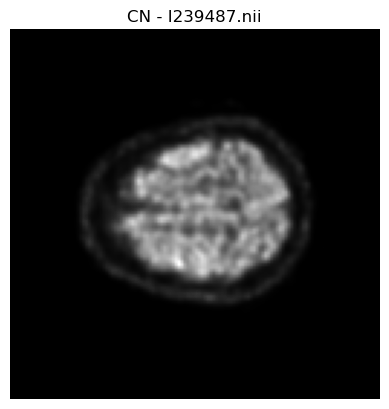

Visualizing MCI: C:/Users/Archana G/OneDrive/Desktop/My projects/MiniProject/nifti_data\MCI\ADNI\002_S_1268\ADNI_Brain_PET__Raw_FDG\2011-04-19_16_37_07.0\I228411\I228411.nii


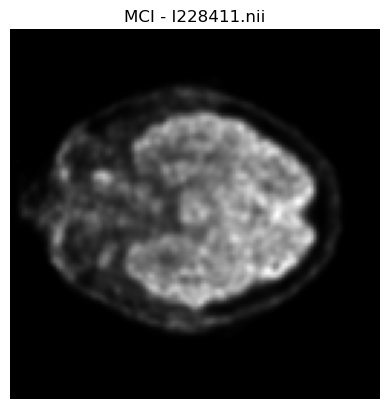

Visualizing EMCI: C:/Users/Archana G/OneDrive/Desktop/My projects/MiniProject/nifti_data\EMCI\ADNI\002_S_2010\ADNI_Brain_PET__Raw_FDG\2012-07-12_08_24_47.0\I316036\I316036.nii


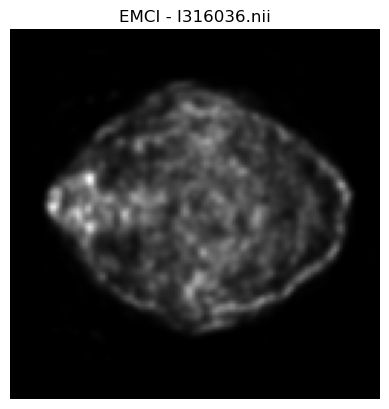

In [119]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

nifti_data_dir = 'C:/Users/Archana G/OneDrive/Desktop/My projects/MiniProject/nifti_data'
class_labels = ['AD', 'CN', 'MCI', 'EMCI']

def visualize_nifti_slice(nifti_file, title):
    nifti_img = nib.load(nifti_file).get_fdata()
    middle_slice = nifti_img[:, :, nifti_img.shape[2] // 4]  
    plt.imshow(middle_slice.T, cmap='gray', origin='lower')  
    plt.title(title)
    plt.axis('off')
    plt.show()

# Function to find one NIfTI file from each class
def find_and_visualize_one_file_per_class(root_dir, class_labels):
    class_files = {label: None for label in class_labels} 
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.nii') or file.endswith('.nii.gz'):
                for label in class_labels:
                    if f'\\{label}\\' in root and class_files[label] is None:  
                        class_files[label] = os.path.join(root, file)
    for label, file_path in class_files.items():
        if file_path:
            print(f"Visualizing {label}: {file_path}")
            visualize_nifti_slice(file_path, f"{label} - {os.path.basename(file_path)}")
        else:
            print(f"No NIfTI file found for class {label}")

find_and_visualize_one_file_per_class(nifti_data_dir, class_labels)


In [ ]:
import os
import pandas as pd

def create_labels_csv(data_dir, output_csv):
    labels = []

    print(f"Starting to walk through directory: {data_dir}")

    for root, _, files in os.walk(data_dir):
        print(f"Checking directory: {root}")
        nii_files = [f for f in files if f.endswith('.nii')]
        if nii_files:
            print(f"Files found: {', '.join(nii_files)}")
            relative_path = os.path.relpath(root, start=data_dir)
            parts = relative_path.split(os.sep)
            
            if len(parts) > 1:
                label = parts[0]
                for file in nii_files:
                    labels.append({'file': os.path.join(root, file), 'label': label})
            else:
                print(f"Parent directory {relative_path} is not a recognized label.")
        else:
            print(f"No .nii files found in directory: {root}")

    if labels:
        df = pd.DataFrame(labels)
        df.to_csv(output_csv, index=False)
        print(f"Labels CSV created: {output_csv}")
    else:
        print("No labels were created. Please check the directory structure and file extensions.")

data_dir = r'C:\Users\Archana G\OneDrive\Desktop\My projects\MiniProject\nifti_data'
output_csv = r'C:\Users\Archana G\OneDrive\Desktop\My projects\MiniProject\labels.csv'

create_labels_csv(data_dir, output_csv)


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

labels_df = pd.read_csv('labels.csv')
train_df, test_df = train_test_split(labels_df, test_size=0.2, random_state=42,stratify = labels_df['label'])
train_df.to_csv('train_labels.csv', index=False)
test_df.to_csv('test_labels.csv', index=False)

In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential()
model.add(layers.Input(shape=(64, 64, 64, 1)))  # Input layer
model.add(layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())  # Add Batch Normalization
model.add(layers.MaxPooling3D((2, 2, 2)))
model.add(layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())  # Add Batch Normalization
model.add(layers.MaxPooling3D((2, 2, 2)))
model.add(layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())  # Add Batch Normalization
model.add(layers.MaxPooling3D((2, 2, 2)))
model.add(layers.Conv3D(256, (3, 3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())  # Add Batch Normalization
model.add(layers.MaxPooling3D((2, 2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.1))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(4, activation='softmax'))  # 4 classes
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower learning rate
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 64, 64, 64, 32)      │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 64, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 32, 32, 32, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 32, 32, 32, 64)      │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 32, 64)      │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 16, 16, 16, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 16, 16, 16, 128)     │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 16, 128)     │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 8, 8, 8, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_3 (Conv3D)                    │ (None, 8, 8, 8, 256)        │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 8, 8, 256)        │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_3 (MaxPooling3D)       │ (None, 4, 4, 4, 256)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       8,389,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,555,652 (36.45 MB)

 Trainable params: 9,554,692 (36.45 MB)

 Non-trainable params: 960 (3.75 KB)

In [43]:
import numpy as np
import pandas as pd
import nibabel as nib
import time
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from scipy.ndimage import zoom

train_df = pd.read_csv('train_labels.csv')
test_df = pd.read_csv('test_labels.csv')
label_encoder = LabelEncoder()
label_encoder.fit(['AD', 'CN', 'MCI', 'EMCI'])  # Make sure this matches your classes

def load_nifti_data(file_paths):
    data = []
    labels = []
    for index, row in file_paths.iterrows():
        file_path = row['file']
        label = row['label']
        img = nib.load(file_path).get_fdata()
        #img = np.resize(img, (64, 64, 64))
        img = zoom(img, (64/img.shape[0], 64/img.shape[1], 64/img.shape[2]), order=1)
        data.append(img)
        labels.append(label)
    return np.array(data), np.array(labels)

X_train, y_train = load_nifti_data(train_df)
X_test, y_test = load_nifti_data(test_df)
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

start_time = time.time()
history = model.fit(X_train, y_train, epochs=20, batch_size= 4, validation_split=0.1)  
end_time = time.time()
print(f"Training Time: {end_time - start_time} seconds")


Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 40s 894ms/step - accuracy: 0.9579 - loss: 0.1376 - val_accuracy: 0.7619 - val_loss: 0.4995
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 994ms/step - accuracy: 0.9733 - loss: 0.0595 - val_accuracy: 0.8571 - val_loss: 0.2672
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 915ms/step - accuracy: 1.0000 - loss: 0.0237 - val_accuracy: 0.8571 - val_loss: 0.3012
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 40s 884ms/step - accuracy: 0.9901 - loss: 0.0294 - val_accuracy: 0.8571 - val_loss: 0.2380
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 39s 857ms/step - accuracy: 1.0000 - loss: 0.0122 - val_accuracy: 0.9048 - val_loss: 0.2306
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 866ms/step - accuracy: 1.0000 - loss: 0.0089 - val_accuracy: 0.9048 - val_loss: 0.2484
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 39s 855ms/step - accuracy: 1.0000 - loss: 0.0106 - val_accuracy: 0.8571 - val_loss: 0.4206
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 39s 861ms/step - accuracy: 1.0000 - loss: 0.0099 - val_accu

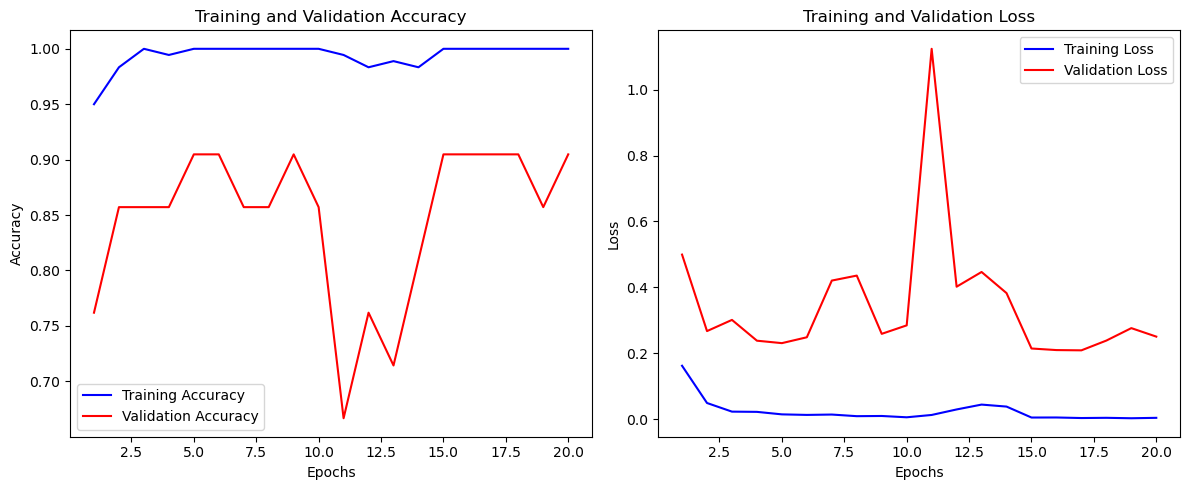

In [45]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



In [47]:
model.save('3d_cnn_model.keras')

In [49]:
from tensorflow.keras.models import load_model
loaded_model = load_model('3d_cnn_model.keras')
loaded_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 64, 64, 64, 32)      │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 64, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 32, 32, 32, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 32, 32, 32, 64)      │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 32, 64)      │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 16, 16, 16, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 16, 16, 16, 128)     │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 16, 128)     │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 8, 8, 8, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_3 (Conv3D)                    │ (None, 8, 8, 8, 256)        │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 8, 8, 256)        │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_3 (MaxPooling3D)       │ (None, 4, 4, 4, 256)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       8,389,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,665,038 (109.35 MB)

 Trainable params: 9,554,692 (36.45 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 19,109,386 (72.90 MB)

In [51]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001318F8BA660> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


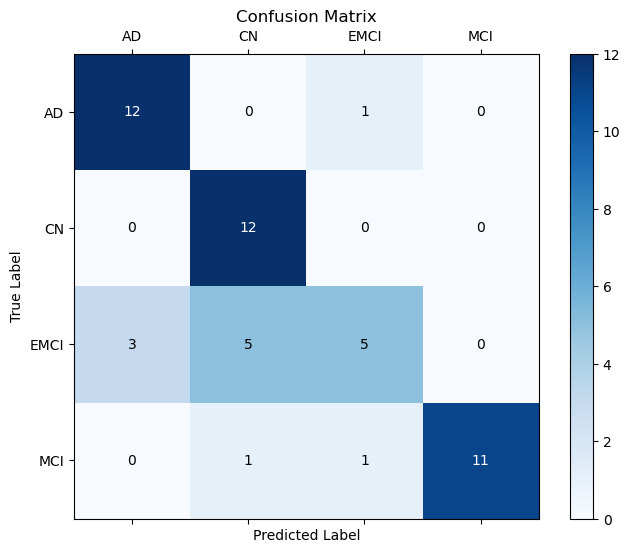

In [53]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.matshow(conf_matrix, cmap='Blues', fignum=1) 
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=range(len(label_encoder.classes_)), labels=label_encoder.classes_)
plt.yticks(ticks=range(len(label_encoder.classes_)), labels=label_encoder.classes_)
for (i, j), val in np.ndenumerate(conf_matrix):
    plt.text(j, i, int(val), ha='center', va='center', color='white' if val > conf_matrix.max()/2 else 'black')

plt.show()


In [55]:
from sklearn.metrics import accuracy_score
y_pred = loaded_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
overall_accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Overall Accuracy: {overall_accuracy:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 945ms/step
Overall Accuracy: 0.7843


In [77]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_3d_cnn_lstm_model(input_shape):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    
    model.add(layers.TimeDistributed(layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')))
    model.add(layers.TimeDistributed(layers.BatchNormalization()))
    model.add(layers.TimeDistributed(layers.MaxPooling3D(pool_size=(2, 2, 2))))    
    model.add(layers.TimeDistributed(layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')))
    model.add(layers.TimeDistributed(layers.BatchNormalization()))
    model.add(layers.TimeDistributed(layers.MaxPooling3D(pool_size=(2, 2, 2))))    
    model.add(layers.TimeDistributed(layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same')))
    model.add(layers.TimeDistributed(layers.BatchNormalization()))
    model.add(layers.TimeDistributed(layers.MaxPooling3D(pool_size=(2, 2, 2))))    
    model.add(layers.TimeDistributed(layers.Conv3D(256, (3, 3, 3), activation='relu', padding='same')))
    model.add(layers.TimeDistributed(layers.BatchNormalization()))
    model.add(layers.TimeDistributed(layers.MaxPooling3D(pool_size=(2, 2, 2))))   
    model.add(layers.TimeDistributed(layers.Flatten()))    
    model.add(layers.LSTM(128, return_sequences=True))
    model.add(layers.LSTM(64))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(4, activation='softmax'))   
    return model
    
input_shape = (1, 64, 64, 64, 1)
model = create_3d_cnn_lstm_model(input_shape)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_73                  │ (None, 1, 64, 64, 64, 32)   │             896 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_74                  │ (None, 1, 64, 64, 64, 32)   │             128 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_75                  │ (None, 1, 32, 32, 32, 32)   │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_76                  │ (None, 1, 32, 32, 32, 64)   │          55,360 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_77                  │ (None, 1, 32, 32, 32, 64)   │             256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_78                  │ (None, 1, 16, 16, 16, 64)   │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_79                  │ (None, 1, 16, 16, 16, 128)  │         221,312 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_80                  │ (None, 1, 16, 16, 16, 128)  │             512 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_81                  │ (None, 1, 8, 8, 8, 128)     │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_82                  │ (None, 1, 8, 8, 8, 256)     │         884,992 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_83                  │ (None, 1, 8, 8, 8, 256)     │           1,024 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_84                  │ (None, 1, 4, 4, 4, 256)     │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_85                  │ (None, 1, 16384)            │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_12 (LSTM)                       │ (None, 1, 128)              │       8,454,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 64)                  │          49,4

 Total params: 9,703,876 (37.02 MB)

 Trainable params: 9,702,916 (37.01 MB)

 Non-trainable params: 960 (3.75 KB)

In [81]:
import numpy as np
import pandas as pd
import nibabel as nib
import time
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models
from scipy.ndimage import zoom

train_df = pd.read_csv('train_labels.csv')
test_df = pd.read_csv('test_labels.csv')
label_encoder = LabelEncoder()
label_encoder.fit(['AD', 'CN', 'MCI', 'EMCI'])  

def load_nifti_data(file_paths):
    data = []
    labels = []
    for index, row in file_paths.iterrows():
        file_path = row['file']
        label = row['label']
        img = nib.load(file_path).get_fdata()
        img = zoom(img, (64/img.shape[0], 64/img.shape[1], 64/img.shape[2]), order=1)
        data.append(img)
        labels.append(label)
    return np.array(data), np.array(labels)

X_train, y_train = load_nifti_data(train_df)
X_test, y_test = load_nifti_data(test_df)
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

X_train = X_train.reshape(X_train.shape[0], 1, 64, 64, 64, 1)  
X_test = X_test.reshape(X_test.shape[0], 1, 64, 64, 64, 1)

start_time = time.time()
history = model.fit(X_train, y_train, epochs=20, batch_size=4, validation_split=0.1)  
end_time = time.time()
print(f"Training Time: {end_time - start_time} seconds")

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.5851 - loss: 1.2505 - val_accuracy: 0.2381 - val_loss: 1.3914
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 989ms/step - accuracy: 0.6029 - loss: 1.1366 - val_accuracy: 0.2381 - val_loss: 1.4104
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 987ms/step - accuracy: 0.6036 - loss: 1.0847 - val_accuracy: 0.2381 - val_loss: 1.5142
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.5907 - loss: 1.0115 - val_accuracy: 0.2381 - val_loss: 1.6437
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.5947 - loss: 0.9627 - val_accuracy: 0.2381 - val_loss: 1.6474
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.6637 - loss: 0.8558 - val_accuracy: 0.2857 - val_loss: 1.5131
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.7029 - loss: 0.8394 - val_accuracy: 0.3810 - val_loss: 1.5831
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.7819 - loss: 0.7001 - val_accuracy: 0.3810 - val

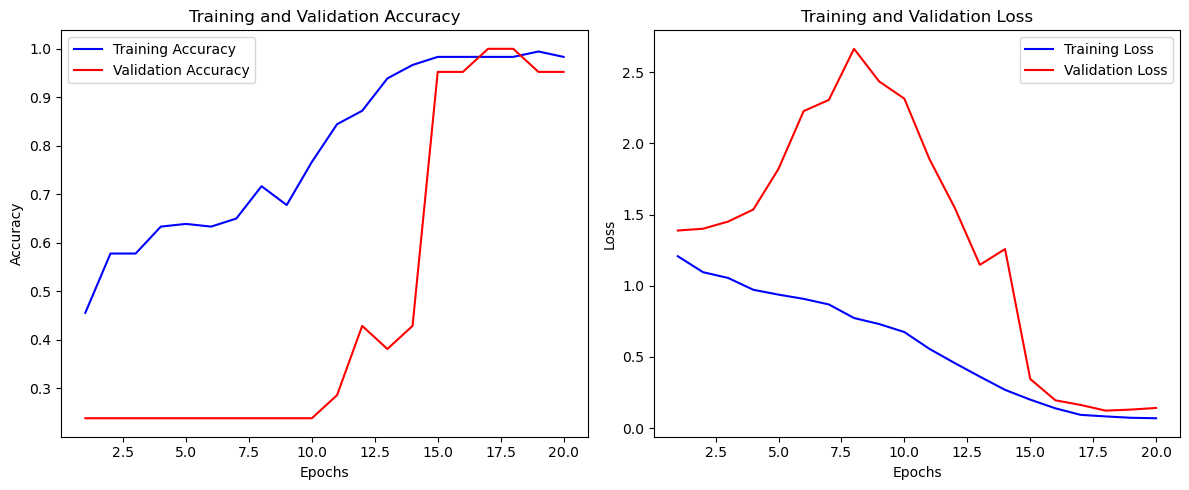

In [104]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [84]:
model.save("3d-cnn-lstm.keras")

In [90]:
from tensorflow.keras.models import load_model
loaded_model1 = load_model('3d-cnn-lstm.keras')
loaded_model1.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_73                  │ (None, 1, 64, 64, 64, 32)   │             896 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_74                  │ (None, 1, 64, 64, 64, 32)   │             128 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_75                  │ (None, 1, 32, 32, 32, 32)   │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_76                  │ (None, 1, 32, 32, 32, 64)   │          55,360 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_77                  │ (None, 1, 32, 32, 32, 64)   │             256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_78                  │ (None, 1, 16, 16, 16, 64)   │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_79                  │ (None, 1, 16, 16, 16, 128)  │         221,312 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_80                  │ (None, 1, 16, 16, 16, 128)  │             512 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_81                  │ (None, 1, 8, 8, 8, 128)     │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_82                  │ (None, 1, 8, 8, 8, 256)     │         884,992 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_83                  │ (None, 1, 8, 8, 8, 256)     │           1,024 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_84                  │ (None, 1, 4, 4, 4, 256)     │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_85                  │ (None, 1, 16384)            │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_12 (LSTM)                       │ (None, 1, 128)              │       8,454,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 64)                  │          49,4

 Total params: 29,109,710 (111.04 MB)

 Trainable params: 9,702,916 (37.01 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 19,405,834 (74.03 MB)

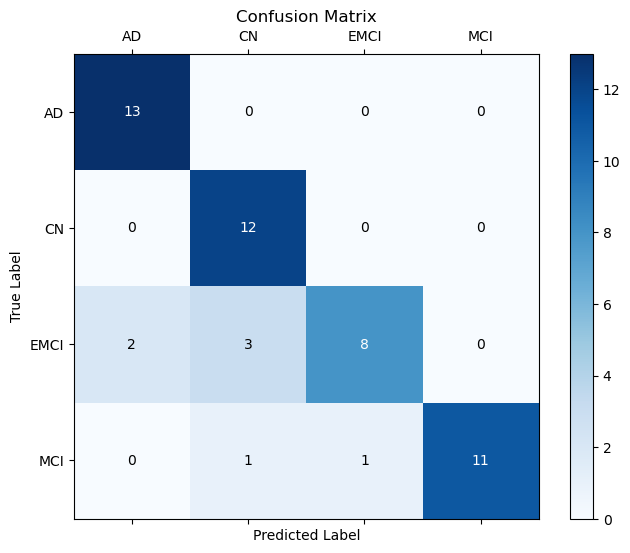

In [102]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
plt.matshow(conf_matrix, cmap='Blues', fignum=1) 
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=range(len(label_encoder.classes_)), labels=label_encoder.classes_)
plt.yticks(ticks=range(len(label_encoder.classes_)), labels=label_encoder.classes_)
for (i, j), val in np.ndenumerate(conf_matrix):
    plt.text(j, i, int(val), ha='center', va='center', color='white' if val > conf_matrix.max()/2 else 'black')

plt.show()

In [96]:
from sklearn.metrics import accuracy_score
y_pred = loaded_model1.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
overall_accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Overall Accuracy: {overall_accuracy:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
Overall Accuracy: 0.9412


In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_3d_cnn_model(input_shape):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))    
    model.add(layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(layers.Conv3D(256, (3, 3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(layers.Flatten())  # Flatten to feed into SVM later
    return model

In [16]:
import numpy as np
import pandas as pd
import nibabel as nib
from sklearn.preprocessing import LabelEncoder
from scipy.ndimage import zoom
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
def load_nifti_data(file_paths):
    data = []
    labels = []
    for index, row in file_paths.iterrows():
        file_path = row['file']
        label = row['label']
        try:
            img = nib.load(file_path).get_fdata()
            img = zoom(img, (64/img.shape[0], 64/img.shape[1], 64/img.shape[2]), order=1)  # Resize to 64x64x64
            img = img / np.max(img)  # Normalize
            data.append(img)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    return np.array(data), np.array(labels)

train_df = pd.read_csv('train_labels.csv')
test_df = pd.read_csv('test_labels.csv')
label_encoder = LabelEncoder()
label_encoder.fit(['AD', 'CN', 'MCI', 'EMCI'])  

X_train, y_train = load_nifti_data(train_df)
X_test, y_test = load_nifti_data(test_df)
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

input_shape = (64, 64, 64, 1)
cnn_model = create_3d_cnn_model(input_shape)
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

X_train_features = cnn_model.predict(X_train)
X_test_features = cnn_model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 949ms/step


In [28]:
X_train_features, X_val_features, y_train, y_val = train_test_split(X_train_features, y_train, test_size=0.2)
svm_model = SVC(kernel='linear', C=1)
svm_model.fit(X_train_features, y_train)

SVC(C=1, kernel='linear')

In [30]:
val_predictions = svm_model.predict(X_val_features)
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

test_predictions = svm_model.predict(X_test_features)
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Validation Accuracy: 62.50%
Test Accuracy: 62.75%


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_3d_cnn_rnn_model(input_shape):
    model = models.Sequential()
    model.add(layers.TimeDistributed(layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same'), input_shape=input_shape))
    model.add(layers.TimeDistributed(layers.BatchNormalization()))
    model.add(layers.TimeDistributed(layers.MaxPooling3D(pool_size=(2, 2, 2))))
    model.add(layers.TimeDistributed(layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')))
    model.add(layers.TimeDistributed(layers.BatchNormalization()))
    model.add(layers.TimeDistributed(layers.MaxPooling3D(pool_size=(2, 2, 2))))
    model.add(layers.TimeDistributed(layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same')))
    model.add(layers.TimeDistributed(layers.BatchNormalization()))
    model.add(layers.TimeDistributed(layers.MaxPooling3D(pool_size=(2, 2, 2))))
    model.add(layers.TimeDistributed(layers.Flatten()))  # Flatten for RNN input
    model.add(layers.SimpleRNN(128, return_sequences=True))
    model.add(layers.SimpleRNN(64))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.2))  # Regularization
    model.add(layers.Dense(4, activation='softmax'))  # 4 classes: AD, CN, MCI, EMCI
    return model

In [5]:
import numpy as np
import pandas as pd
import nibabel as nib
from sklearn.preprocessing import LabelEncoder
from scipy.ndimage import zoom
def load_nifti_data(file_paths):
    data = []
    labels = []
    for index, row in file_paths.iterrows():
        file_path = row['file']
        label = row['label']
        try:
            img = nib.load(file_path).get_fdata()
            img = zoom(img, (64/img.shape[0], 64/img.shape[1], 64/img.shape[2]), order=1)  
            data.append(img)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    return np.array(data), np.array(labels)

train_df = pd.read_csv('train_labels.csv')
test_df = pd.read_csv('test_labels.csv')
label_encoder = LabelEncoder()
label_encoder.fit(['AD', 'CN', 'MCI', 'EMCI'])  
X_train, y_train = load_nifti_data(train_df)
X_test, y_test = load_nifti_data(test_df)
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)
X_train = X_train.reshape(X_train.shape[0], -1, 64, 64, 64, 1)
X_test = X_test.reshape(X_test.shape[0], -1, 64, 64, 64, 1)

input_shape = (None, 64, 64, 64, 1)  
model = create_3d_cnn_rnn_model(input_shape)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20, batch_size=4, validation_split=0.1)

C:\Anaconda\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.4349 - loss: 1.2820 - val_accuracy: 0.3333 - val_loss: 1.3881
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.6603 - loss: 1.0653 - val_accuracy: 0.3333 - val_loss: 1.4115
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.7451 - loss: 0.9604 - val_accuracy: 0.3333 - val_loss: 1.4193
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.8277 - loss: 0.8134 - val_accuracy: 0.3333 - val_loss: 1.4044
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.8688 - loss: 0.7426 - val_accuracy: 0.3810 - val_loss: 1.4148
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.8726 - loss: 0.6969 - val_accuracy: 0.1905 - val_loss: 1.4239
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9178 - loss: 0.5899 - val_accuracy: 0.1905 - val_loss: 1.4135
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.9193 - loss: 0.5402 - val_accuracy: 0.3810 - val_loss:

In [8]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Overall accuracy of 3D CNN-RNN: {test_acc * 100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 678ms/step - accuracy: 0.8642 - loss: 0.6235
Overall accuracy of 3D CNN-RNN: 84.31%


In [38]:
model.save('3d-cnn-rnn.keras')

In [48]:
def load_test_data():
    test_df = pd.read_csv('test_labels.csv')
    label_encoder = LabelEncoder()
    label_encoder.fit(['AD', 'CN', 'MCI', 'EMCI'])  
    X_test, y_test = load_nifti_data(test_df)
    X_test = X_test[..., np.newaxis]
    y_test = label_encoder.transform(y_test)
    return [X_test,y_test]
def reshape_test_data(X_test):
    X_test = X_test.reshape(X_test.shape[0], -1, 64, 64, 64, 1)
    return X_test

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 728ms/step - accuracy: 0.7206 - loss: 0.7522
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 765ms/step - accuracy: 0.8172 - loss: 0.6477
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 875ms/step - accuracy: 0.9400 - loss: 0.1425


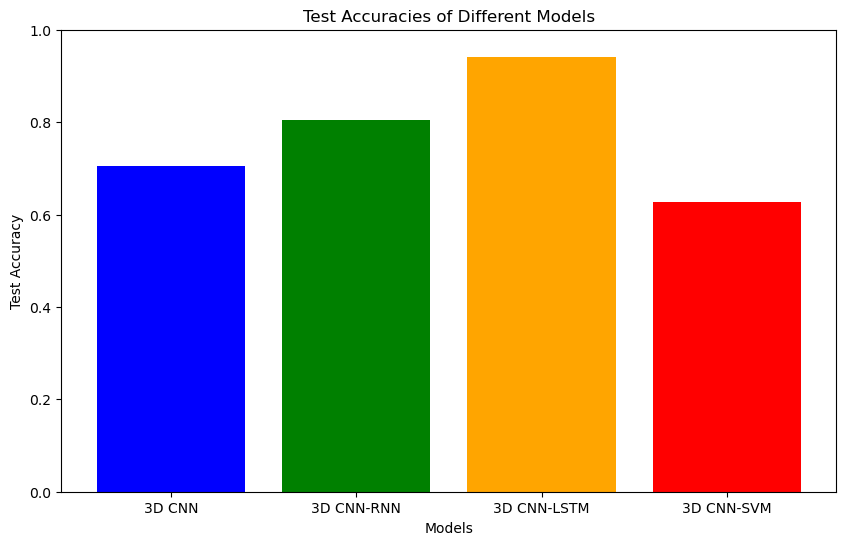

In [50]:
cnn_model = tf.keras.models.load_model('3d_cnn_model.keras')
X_test,y_test = load_test_data()
cnn_accuracy = cnn_model.evaluate(X_test, y_test)[1]  
cnn_rnn_model = tf.keras.models.load_model('3d-cnn-rnn.keras')
X_test = reshape_test_data(X_test)
cnn_rnn_accuracy = cnn_rnn_model.evaluate(X_test, y_test)[1]
cnn_lstm_model = tf.keras.models.load_model('3d-cnn-lstm.keras')
cnn_lstm_accuracy = cnn_lstm_model.evaluate(X_test, y_test)[1]

accuracies = {
    "3D CNN": cnn_accuracy,
    "3D CNN-RNN": cnn_rnn_accuracy,
    "3D CNN-LSTM": cnn_lstm_accuracy,
    "3D CNN-SVM": test_accuracy
}


plt.figure(figsize=(10, 6))
model_names = list(accuracies.keys())
model_accuracies = list(accuracies.values())
plt.bar(model_names, model_accuracies, color=['blue', 'green', 'orange', 'red'])
plt.title("Test Accuracies of Different Models")
plt.xlabel("Models")
plt.ylabel("Test Accuracy")
plt.ylim([0, 1])  
plt.show()